In [1]:
import pandas as pd
import numpy as np
import os
import io
import gzip


1. Lectura de los archivos en raw, y me creo los archivos parquet que voy a utilizar

In [2]:
df = pd.read_csv('../../data/raw/train.csv')
df_test_nolabel = pd.read_csv('../../data/raw/test_nolabel.csv')
df_sample_submission= pd.read_csv('../../data/raw/sample_submission.csv')

# df_train = df_test_nolabel
#df_train = pd.read_parquet('../data/agregado_diario_2019-2021.parquet')

In [3]:
df

,id,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,bd9d6267ec5,1523195006,"P-SCAPE LAND DESIGN, LLC",NORTHFIELD,OH,CITIZENS BANK NATL ASSOC,RI,1-Nov-05,2006,2,...,0,2,0,1,N,N,31-Dec-05,"$8,000.00",$0.00,1
1,9eebf6d8098,1326365010,The Fresh & Healthy Catering C,CANTON,OH,"FIRSTMERIT BANK, N.A.",OH,6-Jun-05,2005,2,...,1,2,1,1,N,N,31-Jul-05,"$166,000.00",$0.00,1
2,83806858500,6179584001,AARON MASON & HOWE LLC,SAWYERWOOD,OH,"PNC BANK, NATIONAL ASSOCIATION",OH,18-Mar-03,2003,2,...,4,2,1,2,Y,N,31-Mar-03,"$25,000.00",$0.00,1
3,a21ab9cb3af,8463493009,MID OHIO CAR WASH,COLUMBUS,OH,THE HUNTINGTON NATIONAL BANK,OH,28-Jun-95,1995,2,...,0,0,1,0,N,N,31-Jan-96,"$220,100.00",$0.00,1
4,883b5e5385e,3382225007,Bake N Brew LLC,Newark,OH,THE HUNTINGTON NATIONAL BANK,OH,16-Apr-09,2009,0,...,0,0,0,1,N,N,31-May-09,"$25,000.00",$0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22830,4f9443d2a46,1573725008,"SIBILA RACE ENGINEERING, INC",MASSILLON,OH,CITIZENS BANK NATL ASSOC,RI,9-Dec-05,2006,1,...,0,1,0,1,N,N,31-Dec-05,"$70,000.00",$0.00,1
22831,798db2753a7,2011184008,ENVIRO SHIELD POWER WASHING,SPRINGBORO,OH,"PNC BANK, NATIONAL ASSOCIATION",OH,27-Apr-98,1998,2,...,0,0,1,0,N,Y,31-May-98,"$30,000.00",$0.00,1
22832,ddb3c5e9bff,4082983001,"MAINLINE TRCK&TRAILR SRVC, INC",BEDFORD,OH,GROWTH CAPITAL CORP.,OH,9-May-90,1990,16,...,6,10,1,0,N,N,13-Feb-91,"$92,000.00",$0.00,1
22833,407200a5dfe,7783283010,TIN BOX STUDIO,CINCINNATI,OH,KEYBANK NATIONAL ASSOCIATION,OH,10-Nov-94,1995,1,...,0,0,1,0,N,Y,31-Jan-95,"$20,000.00",$0.00,1


2. Cambiar los valores correspondientes.

La gran mayoría de los valores son de tipo objet, int64 y float64, tienen que ser acorde a sus valores.

Primero cambio los valores de las fechas, que son Approval Date y DisbursementDate que están puesto con letra escrita en vez de en el formato de numero.
Después cambiamos los valores que están raros y no se adaptan

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22835 entries, 0 to 22834
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 22835 non-null  object 
 1   LoanNr_ChkDgt      22835 non-null  int64  
 2   Name               22834 non-null  object 
 3   City               22834 non-null  object 
 4   State              22835 non-null  object 
 5   Bank               22813 non-null  object 
 6   BankState          22813 non-null  object 
 7   ApprovalDate       22835 non-null  object 
 8   ApprovalFY         22835 non-null  int64  
 9   NoEmp              22835 non-null  int64  
 10  NewExist           22833 non-null  float64
 11  CreateJob          22835 non-null  int64  
 12  RetainedJob        22835 non-null  int64  
 13  FranchiseCode      22835 non-null  int64  
 14  UrbanRural         22835 non-null  int64  
 15  RevLineCr          22744 non-null  object 
 16  LowDoc             227

* *DisbursementDate* => transformar la fecha
* *Name* => String, Si no sabemos lo ponemos Unknown
* *City* => String, Si no sabemos lo ponemos Unknown
* *State* => Son todosde tipo OH
* *Bank* => Si quitamos los None es de tipo String, Si no sabemos lo ponemos Unknown
* *BankState* => Si quitamos los None es de tipo String, Si no sabemos lo ponemos Unknown
* *NewExist* => 2 / 1 / 0, int, y poner la media donde sea nulo; 

    1 = Existing business, 2 = New business; 

    Si no lo sabemos ponemos vieja empresa que es la mayoría, es decir, que ya existía la empresa, 0. 

    Por lo que corresponde con 0 = Existing y 1 = New
* *RevLineCr* => array(['N', 'Y', '0', 'T', None, '`'], dtype=object, 

    Hay que limpiarlo, sabiendo que tiene que ser Y = Yes, N = No, para el que no sepamos ponemos la mayoría; después ponemos True => 1 y False => 0
* *LowDoc* => array(['N', 'Y', None, 'A', '0', 'S', 'R', 'C'], dtype=object)

    Tiene que ser Y = Yes, N = No, para el que no sepamos ponemos la mayoría; después ponemos True => 1 y False => 0
* *DisbursementGross* => Quitar el dolar y hacerlo double
* *BalanceGross* => Quitar el dolar y hacerlo double y donde sea nulo

In [5]:
import pandas as pd
import numpy as np

def conversion(df):
    """
    Función para convertir el DataFrame
    
    Args:
    - df: DataFrame con los datos
    
    Returns:
    - df_train
    """
    # Copiar el DataFrame
    df_train = df.copy()

    ### Conversion de valores 
    # Conversión de fechas a formato Datetime
    df_train['ApprovalDate'] = pd.to_datetime(df_train['ApprovalDate'])
    df_train['DisbursementDate'] = pd.to_datetime(df_train['DisbursementDate'])

    ### Limpiar y convertir a float 'DisbursementGross' y 'BalanceGross'
    df_train['DisbursementGross'] = df_train['DisbursementGross'].replace('[\$,]', '', regex=True).astype(float)
    df_train['BalanceGross'] = df_train['BalanceGross'].replace('[\$,]', '', regex=True).astype(float)
    return df_train

In [6]:
# Conversion de datos
df_train = conversion(df)
df_train = df_train.drop(columns=["id","LoanNr_ChkDgt","Name","State"])
df_train.info()

/tmp/ipykernel_218608/104695433.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train['ApprovalDate'] = pd.to_datetime(df_train['ApprovalDate'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22835 entries, 0 to 22834
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   City               22834 non-null  object        
 1   Bank               22813 non-null  object        
 2   BankState          22813 non-null  object        
 3   ApprovalDate       22835 non-null  datetime64[ns]
 4   ApprovalFY         22835 non-null  int64         
 5   NoEmp              22835 non-null  int64         
 6   NewExist           22833 non-null  float64       
 7   CreateJob          22835 non-null  int64         
 8   RetainedJob        22835 non-null  int64         
 9   FranchiseCode      22835 non-null  int64         
 10  UrbanRural         22835 non-null  int64         
 11  RevLineCr          22744 non-null  object        
 12  LowDoc             22792 non-null  object        
 13  DisbursementDate   22774 non-null  datetime64[ns]
 14  Disbur

/tmp/ipykernel_218608/104695433.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train['DisbursementDate'] = pd.to_datetime(df_train['DisbursementDate'])


In [7]:
df_train.isnull().sum()

City                  1
Bank                 22
BankState            22
ApprovalDate          0
ApprovalFY            0
NoEmp                 0
NewExist              2
CreateJob             0
RetainedJob           0
FranchiseCode         0
UrbanRural            0
RevLineCr            91
LowDoc               43
DisbursementDate     61
DisbursementGross     0
BalanceGross          0
Accept                0
dtype: int64

In [8]:
df_train_accept_0 = df_train[df_train["Accept"]==0]
df_train_accept_0.isnull().sum()

City                  0
Bank                  2
BankState             2
ApprovalDate          0
ApprovalFY            0
NoEmp                 0
NewExist              0
CreateJob             0
RetainedJob           0
FranchiseCode         0
UrbanRural            0
RevLineCr             1
LowDoc               15
DisbursementDate      8
DisbursementGross     0
BalanceGross          0
Accept                0
dtype: int64

In [9]:
def formatear(df):

    ### City    
    # Transformar a mayúsculas y eliminar texto entre paréntesis. Los nulos (1) se sustituyen por la moda.
    df_train = df.copy()
    df_train['City'].fillna(df_train['City'].mode()[0], inplace=True) # se rellenan con la moda
    df_train["City"] = df_train["City"].str.upper()
    df_train = df_train[~df_train["City"].str.contains(r"\d", regex=True, na=False)]
    df_train["City"] = df_train["City"].str.replace(r" \(.*", "", regex=True).str.strip()

    ### Bank. Los nulos se pueden eliminar ya que no están en la clase minoritaria y la moda puede generar ruido
    df_train['Bank'].fillna('Unknown', inplace=True)
    df_train.dropna(subset=["Bank"])
    df_train["Bank"] = df_train["Bank"].str.upper()

    ### BankState - Se comprueba que todos son dos letras. OH es muy mayoritario, se puede sustituir los valores por la moda
    df_train['BankState'].fillna(df_train['BankState'].mode()[0], inplace=True)

    ### Limpiar la columna 'ApprovalFY' para extraer solo los dígitos
    df_train['ApprovalFY'] = df_train['ApprovalFY'].astype(str).str.extract('(\d+)', expand=False)
    df_train['ApprovalFY'] = pd.to_numeric(df_train['ApprovalFY'], errors='coerce')

    ### NewExist - un valor nulo con Accept = 0 - se elimina
    df_train = df_train.dropna(subset=['NewExist'])
    df_train['NewExist'].astype('int64')
    df_train['NewExist'] = df_train['NewExist'].apply(
        lambda x: 1 if x == 2 else (0 if x == 1 else -1)
    )
    df_train = df_train[df_train['NewExist'] != -1]

    ### Crear la columna 'Franchise' basada en 'FranchiseCode'
    if 'Franchise' not in df_train.columns:
        df_train['Franchise'] = df_train['FranchiseCode'].apply(
            lambda x: 0 if x == 0 or x == 1 else 1
        )
        df_train = df_train.drop(columns=["FranchiseCode"])

    ### RevLineCr - solo hay un Accept = 0 en las null, podemos rellenar con la moda
    if df_train['RevLineCr'].nunique() != 2:
        df_train['RevLineCr'] = df_train['RevLineCr'].apply(lambda x: 1 if str(x).strip().upper() in ['Y','T'] 
                                                                else (0 if str(x).strip().upper() in ['N','0'] 
                                                                      else np.nan))
        df_train['RevLineCr'] = df_train['RevLineCr'].astype("Int64")
        mode = df_train['RevLineCr'].mode()
        df_train['RevLineCr'].fillna(mode[0], inplace=True)

    ### LowDoc - Hay 24 valores con Accept = 0 - rellenamos con la moda
    df_train['LowDoc'] = df_train['LowDoc'].apply(lambda x: 1 if str(x).strip().upper() in ['Y'] 
                                                      else (0 if str(x).strip().upper() in ['N','0'] 
                                                            else np.nan))
    df_train['LowDoc'] = df_train['LowDoc'].astype("Int64")
    mode = df_train['LowDoc'].mode()
    df_train['LowDoc'].fillna(mode[0], inplace=True)

    ### DisbursementDate 
    # 1. Restar DisbursementDate de ApprovalDate para obtener la diferencia
    df_train['DisbursementInterval'] = (df_train['DisbursementDate'] - df_train['ApprovalDate']).dt.days
    
    # 2. Calcular la desviación estándar de la diferencia
    std_dev = df_train['DisbursementInterval'].std()
    
    # 3. Rellenar los valores nulos de DisbursementDate con ApprovalDate + desviación estándar
    df_train['DisbursementDate'] = df_train['DisbursementDate'].fillna(df_train['ApprovalDate'] + pd.Timedelta(days=std_dev))
    
    
    return df_train
    

In [10]:
# Conversion de datos
df_train = formatear(df_train)
df_train = df_train.drop(columns=["DisbursementInterval"])
df_train

,City,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept,Franchise
0,NORTHFIELD,CITIZENS BANK NATL ASSOC,RI,2005-11-01,2006,2,1,0,2,1,0,0,2005-12-31,8000.0,0.0,1,0
1,CANTON,"FIRSTMERIT BANK, N.A.",OH,2005-06-06,2005,2,1,1,2,1,0,0,2005-07-31,166000.0,0.0,1,0
2,SAWYERWOOD,"PNC BANK, NATIONAL ASSOCIATION",OH,2003-03-18,2003,2,1,4,2,2,1,0,2003-03-31,25000.0,0.0,1,0
3,COLUMBUS,THE HUNTINGTON NATIONAL BANK,OH,1995-06-28,1995,2,1,0,0,0,0,0,1996-01-31,220100.0,0.0,1,0
4,NEWARK,THE HUNTINGTON NATIONAL BANK,OH,2009-04-16,2009,0,0,0,0,1,0,0,2009-05-31,25000.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22830,MASSILLON,CITIZENS BANK NATL ASSOC,RI,2005-12-09,2006,1,0,0,1,1,0,0,2005-12-31,70000.0,0.0,1,0
22831,SPRINGBORO,"PNC BANK, NATIONAL ASSOCIATION",OH,1998-04-27,1998,2,1,0,0,0,0,1,1998-05-31,30000.0,0.0,1,0
22832,BEDFORD,GROWTH CAPITAL CORP.,OH,1990-05-09,1990,16,0,6,10,0,0,0,1991-02-13,92000.0,0.0,1,0
22833,CINCINNATI,KEYBANK NATIONAL ASSOCIATION,OH,1994-11-10,1995,1,1,0,0,0,0,1,1995-01-31,20000.0,0.0,1,0


In [21]:
# Eliminacion de outliers

columna = "CreateJob"
percentil = 0.998
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99, percentil]
print(percentiles)


percents = df_train[columna].quantile(percentil)
# Filtrar los datos que son menores o iguales al percentil 97.5
filtered_df = df_train[df_train[columna] <= percents]
filtered_df.describe()

[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.998]


,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept,Franchise
count,22772,22772.000000,22772.000000,22772.000000,22772.000000,22772.000000,22772.000000,22772.0,22772.0,22772,2.277200e+04,22772.000000,22772.000000,22772.000000
mean,2001-11-26 23:17:53.107324800,2001.626735,12.316880,0.299930,2.205867,4.769366,0.834270,0.280564,0.135781,2002-03-29 22:28:53.634784640,1.693229e+05,44.149526,0.831987,0.068637
min,1975-09-12 00:00:00,1970.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1975-10-17 00:00:00,0.000000e+00,0.000000,0.000000,0.000000
25%,1997-07-13 06:00:00,1997.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1997-12-31 00:00:00,4.000000e+04,0.000000,1.000000,0.000000
50%,2003-09-15 00:00:00,2003.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,2003-12-31 00:00:00,8.727350e+04,0.000000,1.000000,0.000000
75%,2006-06-15 00:00:00,2006.000000,12.000000,1.000000,2.000000,4.000000,1.000000,1.0,0.0,2006-08-31 00:00:00,1.890000e+05,0.000000,1.000000,0.000000
max,2073-09-12 00:00:00,2014.000000,7538.000000,1.000000,198.000000,1300.000000,2.000000,1.0,1.0,2074-03-11 00:00:00,4.831510e+06,996262.000000,1.000000,1.000000
std,NaN,6.166420,68.177366,0.458237,7.309902,16.276770,0.681394,0.449285,0.342563,NaN,2.493751e+05,6602.234775,0.373886,0.252841


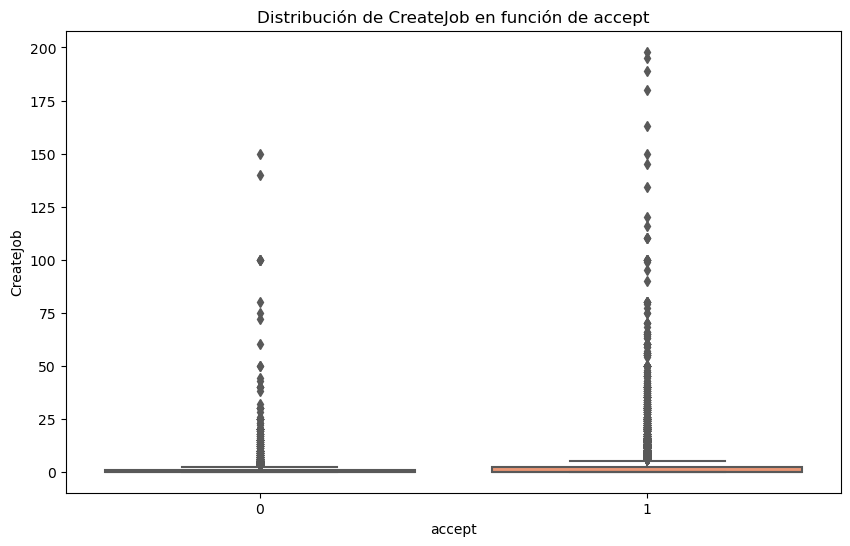

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un boxplot para visualizar la distribución de 'CreateJob' en función de 'accept'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Accept', y='CreateJob', data=filtered_df, palette='Set2')

# Títulos y etiquetas
plt.title('Distribución de CreateJob en función de accept')
plt.xlabel('accept')
plt.ylabel('CreateJob')

# Mostrar el gráfico
plt.show()



In [13]:
    # Transformar a mayúsculas y eliminar texto entre paréntesis en 'City'
    df_train2['City'].fillna(df_train2['City'].mode()[0], inplace=True) # se rellenan con la moda
    df_train2["City"] = df_train2["City"].str.upper()
    df_train2 = df_train2[~df_train2["City"].str.contains(r"\d", regex=True, na=False)]
    df_train2["City"] = df_train2["City"].str.replace(r" \(.*", "", regex=True).str.strip()

    # Rellenar valores nulos en 'Bank' y 'BankState'
    df_train2['Bank'].fillna('Unknown', inplace=True)
    df_train2['BankState'].fillna('Unknown', inplace=True)

    # Transformación de 'NewExist' a valores binarios
    df_train2['NewExist'] = df_train2['NewExist'].apply(
        lambda x: 0 if str(x).strip().replace('.0','') == '1'
                  else (1 if str(x).strip().replace('.0','') == '2'
                        else np.nan))
    df_train2['NewExist'] = df_train2['NewExist'].astype("Int64")
    
    # Limpieza de 'RevLineCr' a valores binarios
    df_train2['RevLineCr'] = df_train2['RevLineCr'].apply(lambda x: 1 if str(x).strip().upper() in ['Y','T'] 
                                                            else (0 if str(x).strip().upper() in ['N','0'] 
                                                                  else np.nan))
    df_train2['RevLineCr'] = df_train2['RevLineCr'].astype("Int64")

    # Limpieza de 'LowDoc' a valores binarios
    df_train2['LowDoc'] = df_train2['LowDoc'].apply(lambda x: 1 if str(x).strip().upper() in ['Y'] 
                                                      else (0 if str(x).strip().upper() in ['N','0'] 
                                                            else np.nan))
    df_train2['LowDoc'] = df_train2['LowDoc'].astype("Int64")

    # Limpiar y convertir a float 'DisbursementGross' y 'BalanceGross'
    df_train2['DisbursementGross'] = df_train2['DisbursementGross'].replace('[\$,]', '', regex=True).astype(float)
    df_train2['BalanceGross'] = df_train2['BalanceGross'].replace('[\$,]', '', regex=True).astype(float)

    # Determinar el nombre del archivo de salida según el valor de 'output_type'
    output_file = '../../data/processed/df_train.csv' if output_type == 0 else '../../data/processed/df_test_nolabel.csv'
    
    # Guardar el DataFrame en el archivo correspondiente
    df_train2.to_csv(output_file, index=False)

NameError: name 'df_train2' is not defined

In [ ]:
# Para guardar el archivo como df_train.csv
output_path = limpiar_y_guardar_df(df_train, 0)  
print("Archivo guardado en:", output_path)

In [ ]:
# Para guardar el archivo como df_test_nolabel.csv
output_path = limpiar_y_guardar_df(df_train, 1)  
print("Archivo guardado en:", output_path)

In [ ]:
df_train2.BalanceGross.value_counts(dropna=False)

In [ ]:
df_train2["RevLineCr"].unique()